# Notebook to construct different noise injection modes

In [3]:
import os
print(os.getcwd())
print(os.getcwd())

%load_ext autoreload
%autoreload 2

/home/lsbicego/dit-editor
/home/lsbicego/dit-editor
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:


import numpy as np
import torch
from PIL import Image



import gc
from accelerate.utils import release_memory

from data.benchmark_data import gather_images
from cache_and_edit.inversion import place_image_in_bounding_box, get_inverted_input_noise, resize_bounding_box, compose_noise_masks



from importlib import reload
import cache_and_edit
reload(cache_and_edit)
from cache_and_edit import *
import cache_and_edit.hooks
reload(cache_and_edit.hooks)


os.environ['HF_HOME'] = '/scratch/izar/lsbicego'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/izar/lsbicego'
os.environ['HF_DATASETS_CACHE'] = '/scratch/izar/lsbicego'


## Load Model

In [5]:


def clear_all_gpu_memory():
    # Run garbage collection
    gc.collect()

    # Get number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} GPU(s).")

    # Iterate through each GPU
    for device_id in range(num_gpus):
        with torch.cuda.device(device_id):
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.reset_accumulated_memory_stats()
            release_memory()
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.ipc_collect()
    print("GPU memory cleared across all available devices.")

clear_all_gpu_memory()

Found 2 GPU(s).
GPU memory cleared across all available devices.


In [6]:
from diffusers import FluxPipeline

dtype = torch.float16
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", 
                                    device_map="balanced",
                                    torch_dtype=dtype)
pipe.set_progress_bar_config(disable=True)




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:

cached_pipe = CachedPipeline(pipe)

## Load images

In [8]:
os_path = "benchmark_images_generations/"
all_images = gather_images(os_path)

example = all_images[0]
print(example.category)
print(example.prompt)

Missing images in benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: fg_mask
Skipping benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: Not all images are present in benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic
Missing images in benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: fg_mask
Skipping benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: Not all images are present in benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style
Loaded 330 images in benchmark_images_generations/
Real-Sketch
a pencil drawing of a puppy in the sunset


/home/lsbicego/dit-editor/data/benchmark_data.py:201: UserWarning: Missing 2 images in benchmark_images_generations/
  warnings.warn(f"Missing {missing_image_counter} images in {image_dir}")


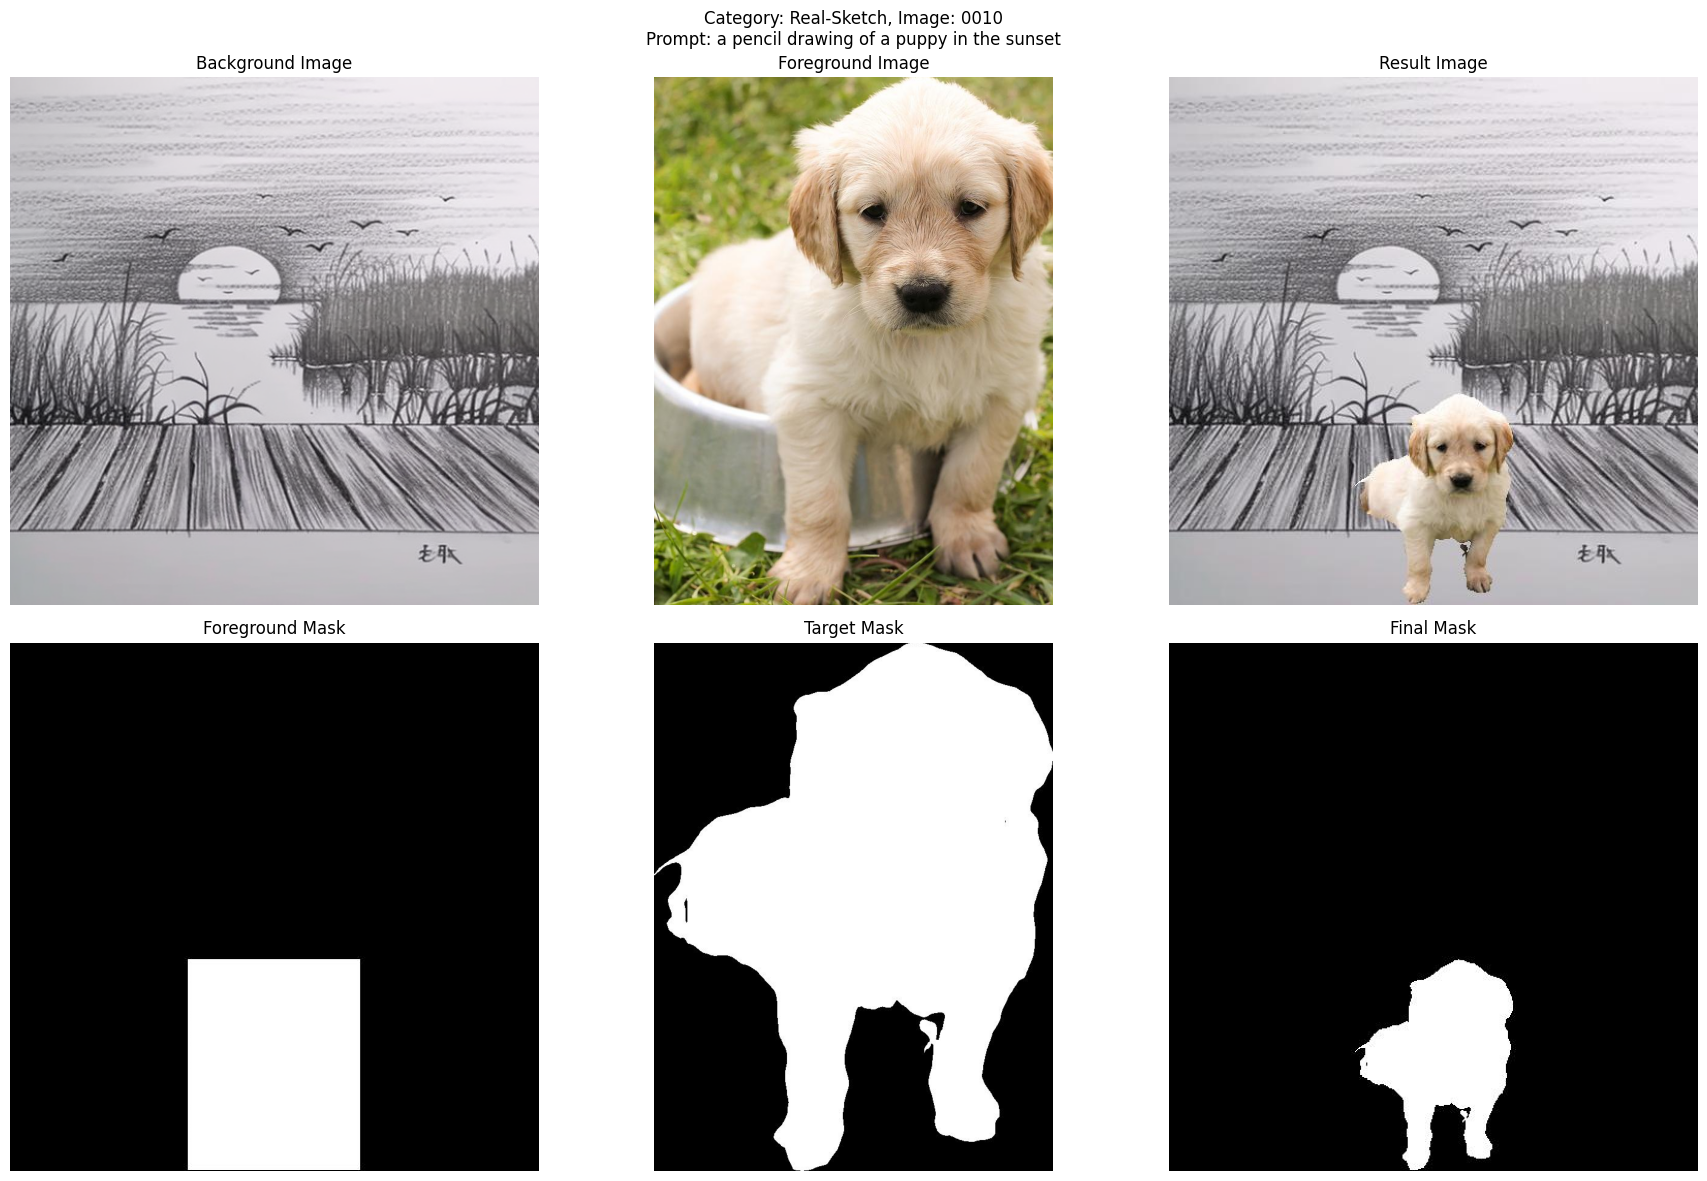

In [9]:
example.plot_sample()

In [10]:
from cache_and_edit.inversion import compose_noise_masks

Segmented and Placed FG Image


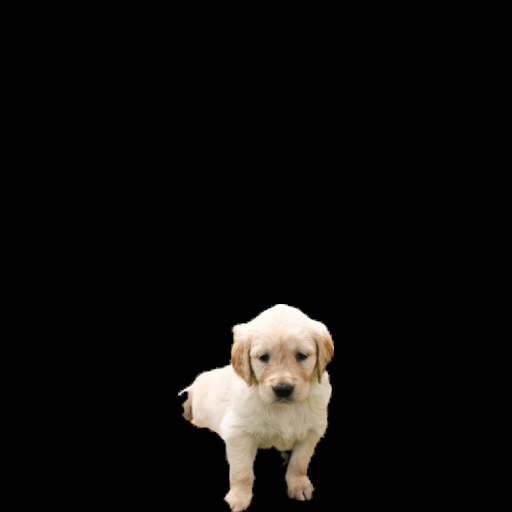

Reframed Segmentation Mask


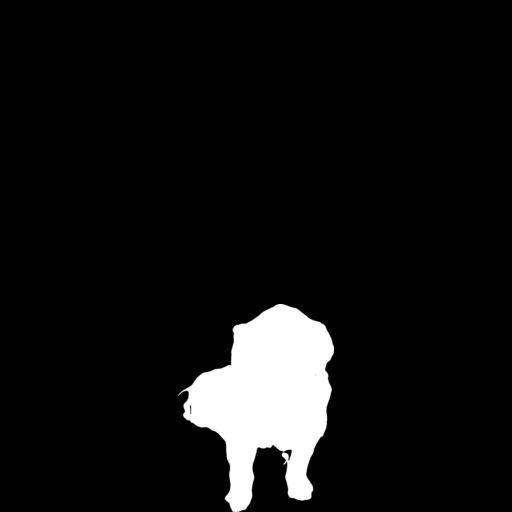

XOR Mask


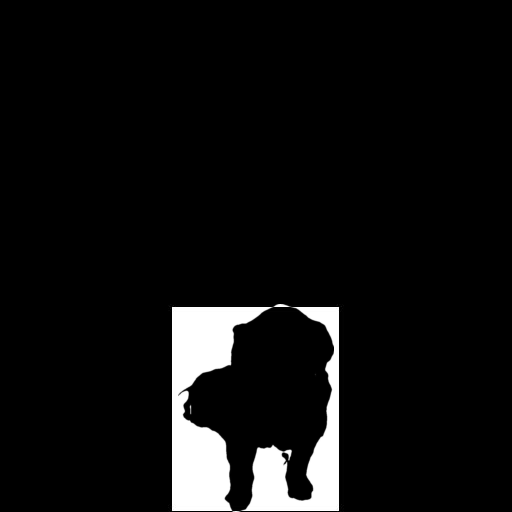

torch.Size([1024, 1])
torch.Size([512, 512])


{'noise': {'composed_noise': tensor([[-0.4893, -0.4219, -0.2061,  ...,  2.4473,  2.7637,  3.0449],
          [-1.4658, -0.3037, -1.1357,  ...,  2.8340,  3.3203,  3.2559],
          [-0.5537, -0.4878, -0.2236,  ...,  2.6582,  2.9902,  2.9082],
          ...,
          [-0.8604, -1.0166, -0.7822,  ...,  3.2012,  3.1367,  2.9160],
          [-0.8423, -0.5215, -1.1445,  ...,  3.2168,  3.0391,  3.0996],
          [-1.3555, -0.6069, -1.3213,  ...,  2.7539,  3.0332,  3.0078]],
         device='cuda:0'),
  'foreground_noise': tensor([[ 0.1221,  0.1553,  0.2102,  ..., -2.3281, -2.3145, -1.7832],
          [ 0.1401,  0.1978,  0.0107,  ..., -2.4336, -1.9414, -1.9277],
          [ 0.1270,  0.1948,  0.0410,  ..., -2.4648, -1.9512, -1.9414],
          ...,
          [ 0.1040,  0.1558, -0.2974,  ..., -2.0840, -2.5215, -2.4238],
          [ 0.0859,  0.2002, -0.3057,  ..., -1.9766, -2.4336, -2.5254],
          [ 0.0137,  0.8794,  0.0239,  ..., -2.3691, -1.9785, -2.2930]],
         device='cuda:0', dtyp

In [11]:
example = all_images[0]

compose_noise_masks(cached_pipe, 
              example.fg_image, 
              example.bg_image, 
              example.target_mask, 
              example.fg_mask, 
              option="segmentation2", 
              photoshop_fg_noise=False,
              num_inversion_steps=1)

Segmented and Palced FG Image


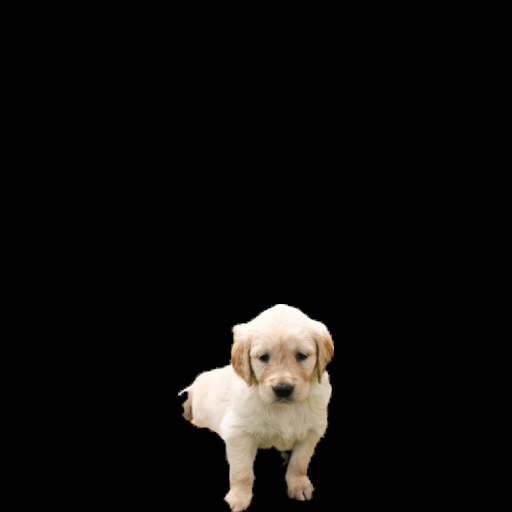

Placed Segmentation Mask


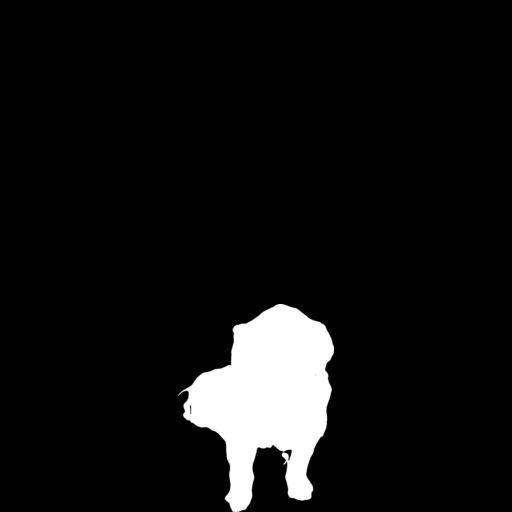

In [12]:
example = all_images[0]

example_noise = compose_noise_masks(cached_pipe, 
              example.fg_image, 
              example.bg_image, 
              example.target_mask, 
              example.fg_mask, 
              option="segmentation1", 
              num_inversion_steps=28)

Available Masks:
latent_segmentation_mask
Available Noises:
composed_noise
foreground_noise
background_noise


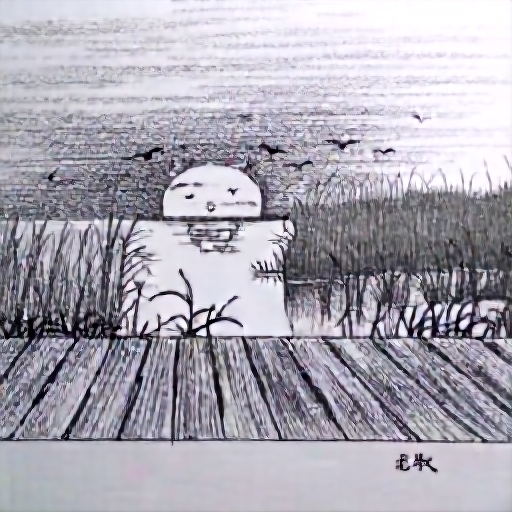

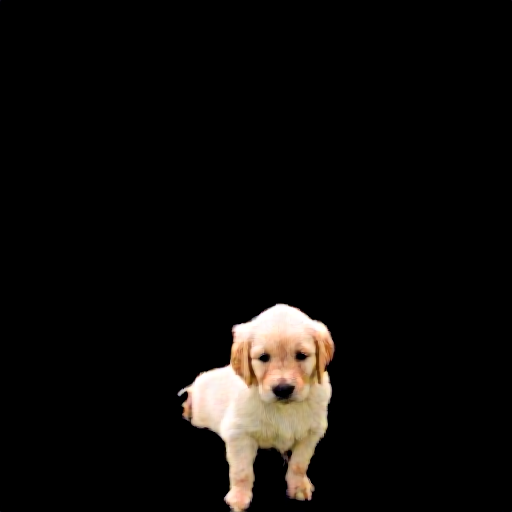

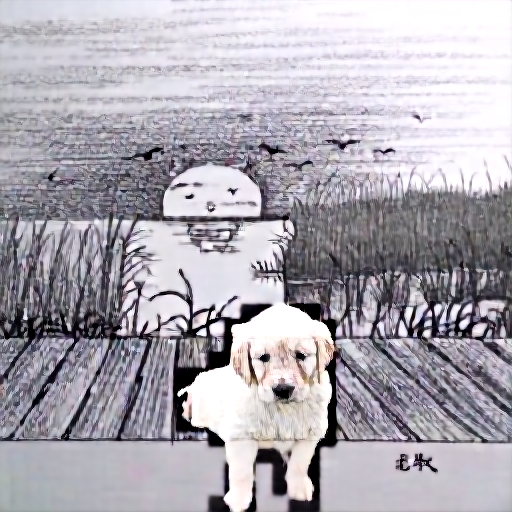

In [17]:
from cache_and_edit.qkv_cache import TFICONAttnProcessor

print("Available Masks:")
for key in example_noise["latent_masks"].keys():
    print(key)
print("Available Noises:")
for key in example_noise["noise"].keys():
    print(key)


    
images = cached_pipe.run_inject_qkv(
    ["", "", ""],
    num_inference_steps=28,
    seed=42,
    guidance_scale=0,
    empty_clip_embeddings=False,
    q_mask=example_noise["latent_masks"]["latent_segmentation_mask"],
    latents=torch.stack(
                        [
                        example_noise["noise"]["background_noise"],
                        example_noise["noise"]["foreground_noise"],
                        example_noise["noise"]["composed_noise"],
                        ]
                    ),
    # latents=torch.stack([bg_noise, fg_noise, tficon_noise]),
    processor_class=TFICONAttnProcessor,
    width=512,
    height=512,
)

display(images[0][0])
display(images[0][1])
display(images[0][2])

## DUMP

In [14]:
### Function to cut image and put it in bounding box (either cut or not cut)
def compose_noise_masks(cached_pipe,
                  foreground_image: Image, 
                  background_image: Image, 
                  target_mask: torch.Tensor,
                  foreground_mask: torch.Tensor,
                  option: str = "bg", # bg, bg_fg, segmentation1, tf_icon
                  photoshop_fg_noise: bool = False,
                  num_inversion_steps: int = 100,
                  ):
    
    # assert options
    assert option in ["bg", "bg_fg", "segmentation1", "segmentation2"], f"Invalid option: {option}"
    
    # calculate size of latent noise for mask resizing
    PATCH_SIZE = 16
    latent_size = background_image.size[0] // PATCH_SIZE
    latents = (latent_size, latent_size)

    # process the options
    if option == "bg":
        # only background noise
        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)
        composed_noise = bg_noise

        all_noise = {
                "composed_noise": composed_noise,
                "background_noise": bg_noise,
                }
        all_latent_masks = {}


    elif option == "bg_fg":

        # resize and scale the image to the bounding box
        reframed_fg_img, resized_mask = place_image_in_bounding_box(
        torch.from_numpy(np.array(foreground_image)),
        (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        print("Placed Foreground Image")
        reframed_fg_img = Image.fromarray(reframed_fg_img.numpy())
        display(reframed_fg_img)

        print("Placed Mask")
        resized_mask_img = Image.fromarray((resized_mask.numpy() * 255).astype(np.uint8))
        display(resized_mask_img)

        # invert resized & padded image
        if photoshop_fg_noise:
            print("Photoshopping FG IMAGE")
            photoshop_img = Image.fromarray(
                (torch.tensor(np.array(background_image)) * ~resized_mask.cpu().unsqueeze(-1) + torch.tensor(np.array(reframed_fg_img)) * resized_mask.cpu().unsqueeze(-1)).numpy()
            )
            display(photoshop_img)
            fg_noise = get_inverted_input_noise(cached_pipe, photoshop_img, num_steps=num_inversion_steps)
        else:
            fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)
        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)

        # overwrite get masked in latent space
        latent_mask = resize_bounding_box(
            resized_mask,
            target_size=latents,
                ).flatten().unsqueeze(-1).to("cuda")

        # compose the noise
        composed_noise = bg_noise * (~latent_mask) + fg_noise * latent_mask
        all_latent_masks = {
            "latent_mask": latent_mask,
                }
        all_noise = {
                "composed_noise": composed_noise,
                "foreground_noise": fg_noise,
                "background_noise": bg_noise,
                    }
        
    elif option == "segmentation1":
        # cut out the object and compose it with the background noise
        
        # segmented foreground image
        segmented_fg_image = torch.tensor(
        np.array(
        foreground_mask.resize(foreground_image.size)
        )).to(torch.bool).unsqueeze(-1) * torch.tensor(
            np.array(foreground_image)
            )
        
        # resize and scale the image to the bounding box
        reframed_fg_img, resized_mask = place_image_in_bounding_box(
        segmented_fg_image,
        (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        print("Segmented and Palced FG Image")
        reframed_fg_img = Image.fromarray(reframed_fg_img.numpy())
        display(reframed_fg_img)

        resized_mask_img = Image.fromarray((resized_mask.numpy() * 255).astype(np.uint8))

        # resize and scale the mask itself
        foreground_mask = foreground_mask.convert("RGB") # to avoid extraction of contours and make work with function
        reframed_segmentation_mask, resized_mask = place_image_in_bounding_box(
            torch.from_numpy(np.array(foreground_mask)),
            (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        reframed_segmentation_mask = reframed_segmentation_mask.numpy()
        reframed_segmentation_mask_img = Image.fromarray(reframed_segmentation_mask)
        print("Placed Segmentation Mask")
        display(reframed_segmentation_mask_img)

        # invert resized & padded image 
        # fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)

        if photoshop_fg_noise:
            # temporarily convert to apply mask
            print("Photoshopping FG IMAGE")
            seg_mask_temp = torch.from_numpy(reframed_segmentation_mask).bool()
            bg_temp = torch.tensor(np.array(background_image))
            fg_temp = torch.tensor(np.array(reframed_fg_img))

            photoshop_img = Image.fromarray(
                (bg_temp * (~seg_mask_temp) + fg_temp * seg_mask_temp).numpy()
            ).convert("RGB")
            display(photoshop_img)
            fg_noise = get_inverted_input_noise(cached_pipe, photoshop_img, num_steps=num_inversion_steps)
        else:
            fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)


        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)

        # overwrite background in resized mask
        # convert mask from 512x512x3 to 512x512 first
        reframed_segmentation_mask = reframed_segmentation_mask[:, :, 0]
        reframed_segmentation_mask = torch.from_numpy(reframed_segmentation_mask).to(dtype=bool)
        latent_mask = resize_bounding_box(
            reframed_segmentation_mask,
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")

        # compose noise
        composed_noise = bg_noise * (~latent_mask) + fg_noise * latent_mask

        all_latent_masks = {
            "latent_segmentation_mask": latent_mask,
            }
        all_noise = {
                "composed_noise": composed_noise,
                "foreground_noise": fg_noise,
                "background_noise": bg_noise,
                    }

        
    elif option == "segmentation2":
        # add random noise in the background

        # segmented foreground image
        segmented_fg_image = torch.tensor(
        np.array(
        foreground_mask.resize(foreground_image.size)
        )).to(torch.bool).unsqueeze(-1) * torch.tensor(
            np.array(foreground_image)
            )
        
        # resize and scale the image to the bounding box
        reframed_fg_img, resized_mask = place_image_in_bounding_box(
        segmented_fg_image,
        (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        print("Segmented and Placed FG Image")
        reframed_fg_img = Image.fromarray(reframed_fg_img.numpy())
        display(reframed_fg_img)

        # resize and scale the mask itself
        foreground_mask = foreground_mask.convert("RGB")
        reframed_segmentation_mask, resized_mask = place_image_in_bounding_box(
            torch.from_numpy(np.array(foreground_mask)),
            (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        reframed_segmentation_mask = reframed_segmentation_mask.numpy()
        reframed_segmentation_mask_img = Image.fromarray(reframed_segmentation_mask)
        print("Reframed Segmentation Mask")
        display(reframed_segmentation_mask_img)

        xor_mask = target_mask ^ np.array(reframed_segmentation_mask_img.convert("L"))
        print("XOR Mask")
        display(Image.fromarray(xor_mask))

        # invert resized & padded image 
        # fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)
        if photoshop_fg_noise:
            print("Photoshopping FG IMAGE")
            # temporarily convert to apply mask
            seg_mask_temp = torch.from_numpy(reframed_segmentation_mask).bool()
            bg_temp = torch.tensor(np.array(background_image))
            fg_temp = torch.tensor(np.array(reframed_fg_img))

            photoshop_img = Image.fromarray(
                (bg_temp * (~seg_mask_temp) + fg_temp * seg_mask_temp).numpy()
            ).convert("RGB")
            display(photoshop_img)
            fg_noise = get_inverted_input_noise(cached_pipe, photoshop_img, num_steps=num_inversion_steps)
        else:
            fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)
        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)

        # overwrite background in resized mask
        # convert mask from 512x512x3 to 512x512
        reframed_segmentation_mask = reframed_segmentation_mask[:, :, 0]
        reframed_segmentation_mask = torch.from_numpy(reframed_segmentation_mask).to(dtype=bool)

        # get all masks in latents and move to device
        latent_seg_mask = resize_bounding_box(
            reframed_segmentation_mask,
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")
        print(latent_seg_mask.shape)


        latent_xor_mask = resize_bounding_box(
            torch.from_numpy(xor_mask),
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")


        print(resized_mask.shape)
        latent_target_mask = resize_bounding_box(
            resized_mask,
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")

        # implement x∗T = xrT ⊙Mseg +xmT ⊙(1−Muser)+z⊙(Muser ⊕Mseg)
        bg = bg_noise * (~latent_target_mask)
        fg = fg_noise * latent_seg_mask
        boundary = latent_xor_mask * torch.randn(latent_xor_mask.shape).to("cuda")
        composed_noise = bg + fg + boundary

        all_latent_masks = {
            "latent_target_mask": latent_target_mask,
            "latent_segmentation_mask": latent_seg_mask,
            "latent_xor_mask": latent_xor_mask,
                            }
        all_noise = {
                "composed_noise": composed_noise,
                "foreground_noise": fg_noise,
                "background_noise": bg_noise,
                    }
    # output 
    return {
        "noise": all_noise,
        "latent_masks": all_latent_masks,
            }
